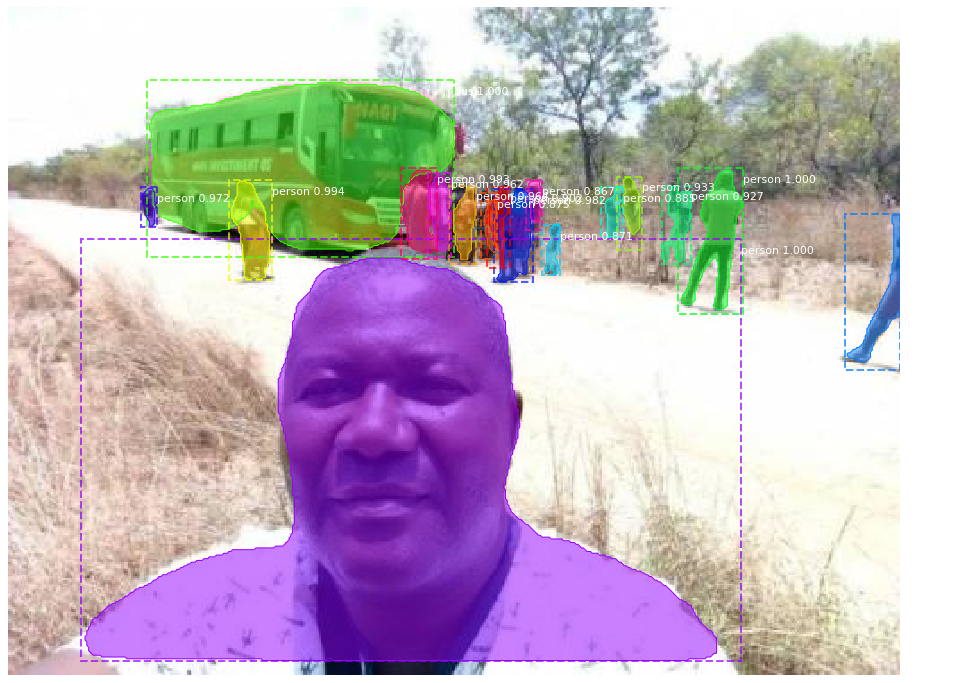

In [8]:
#darame로부터 전경 사진을 전달받아 Mask_RCNN으로 segmentation하여 display

from mrcnn.config import Config
from mrcnn import model as modellib
import mrcnn
import numpy as np
import colorsys
import argparse
import imutils
import random
import cv2
import os
from PIL import Image
import glob
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib.patches import Polygon
from matplotlib import patches,  lines
from skimage.measure import find_contours
#from mrcnn.visualize import display_instances
%matplotlib inline

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = pyplot.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height)
    ax.set_xlim(width)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        Image.fromarray(masked_image.astype(np.uint8)).save('output/display_maskes.png')

def load_foreground(foreground_path):
    try:
        foreground= glob.glob(foreground_path+'/*.jpg')[0]
    except:
        foreground= glob.glob(foreground_path+'/*.png')[0]

    foreground = load_img(foreground)

    return foreground

def do_MRCNN(model_path, foreground_path , config , class_names):
    
    foreground = load_foreground(foreground_path)

    model = modellib.MaskRCNN(mode="inference", config=config, model_dir=model_path)

    model.load_weights('mask_rcnn_coco.h5', by_name=True)

    foreground_ = img_to_array(foreground)
    
    results = model.detect([foreground_], verbose=0) 
    
    r = results[0]
    
    display_instances(foreground_, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
    
    #pyplot.savefig('output/display_maskes.png', bbox_inches='tight')
    
    return r


def main():
    model_path='C:/Users/user/anaconda3/Lib/site-packages/Mask_RCNN'
    foreground_path='img/foreground'    

    class myMaskRCNNConfig(Config):
        # give the configuration a recognizable name
        NAME = "MaskRCNN_inference"
 
        # set the number of GPUs to use along with the number of images
        # per GPU
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1
 
        # number of classes (we would normally add +1 for the background
        # but the background class is *already* included in the class
        # names)
        NUM_CLASSES = 1+80
    
    class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
     'bus', 'train', 'truck', 'boat', 'traffic light',
     'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
     'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
     'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
     'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
     'kite', 'baseball bat', 'baseball glove', 'skateboard',
     'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
     'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
     'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
     'donut','cake', 'chair', 'couch', 'potted plant', 'bed',
     'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
     'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
     'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
     'teddy bear', 'hair drier', 'toothbrush']
    
    config = myMaskRCNNConfig() 
    
    result = do_MRCNN(model_path, foreground_path, config, class_names)

    np.savez('result.npz', rois=result['rois'], masks=result['masks'], classId=result['class_ids'])
    
if __name__== "__main__":
    main()